In [2]:
import os
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pennylane as qml

import git
repo_path = git.Repo('.', search_parent_directories=True).working_tree_dir

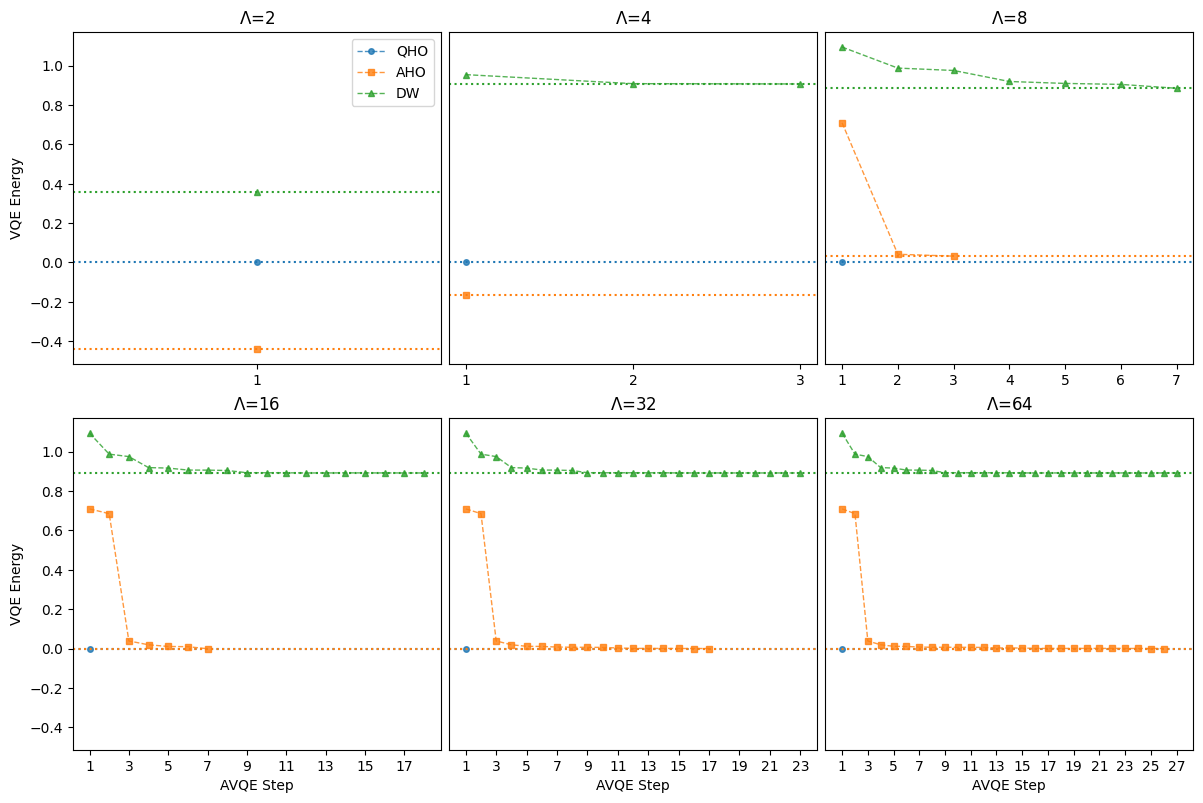

In [12]:
markers = ["o", "s", "^", "D", "v", "P", "*", "X"]
potentials = ["QHO","AHO","DW"]
cutoffs = [2,4,8,16,32,64]

#plt.figure(figsize=(7,4))
fig, axes = plt.subplots(2, 3, figsize=(12,8), sharex=False, sharey=True)

for i, cutoff in enumerate(cutoffs):
    row, col = divmod(i, 3)         
    ax = axes[row, col]

    for potential, marker in zip(potentials,markers):

        num_qubits = int(np.log2(cutoff)+1)

        dpath = os.path.join(repo_path, r"SUSY\SUSY QM\PennyLane\COBYQA\qml.expval\Adaptive-VQE\StatevectorFiles\{}\data_{}.txt".format(potential,cutoff))

        with open(dpath, "r", encoding="utf-8") as file:
            content = file.read()

        json_part = content.split("###############################")[0].strip()
        data = json.loads(json_part)

        min_eigenvalue = data['min_eigenvalue']
        energies = data['best_energy_list_reduced']

        label = f"{potential}{cutoff}"

        line, = ax.plot(range(1, len(energies) + 1), energies, marker=marker, markersize= 4, linestyle='--', alpha=0.8, linewidth=1, label=potential)
        colour = line.get_color()
        ax.axhline(y=min_eigenvalue, color=colour, linestyle=':')#, label="$E_{exact}$ =" + f"{min_eigenvalue:.6f}")

        ax.set_title(f"$\\Lambda$={cutoff}")

        xticks = range(1, len(energies)  + 1)

        if len(xticks) >= 18:
            ax.set_xticks(xticks[::2])
        else:
           ax.set_xticks(xticks)
        #ax.grid(True)

for c in range(1, axes.shape[1]):
    for ax in axes[:, c]:
        ax.tick_params(left=False, labelleft=False)

# x-labels only on the bottom row
for ax in axes[-1, :]:
    ax.set_xlabel('AVQE Step')

# y-label only on the first column
for ax in axes[:, 0]:
    ax.set_ylabel('VQE Energy')

axes[0, 0].legend()

fig.tight_layout(pad=0.6)
plt.show()
#plt.savefig(r"C:\Users\Johnk\Documents\PhD\Quantum Computing Code\Quantum-Computing\SUSY\SUSY QM\PennyLane\ADAPT-VQE\Files\OpPath.png")


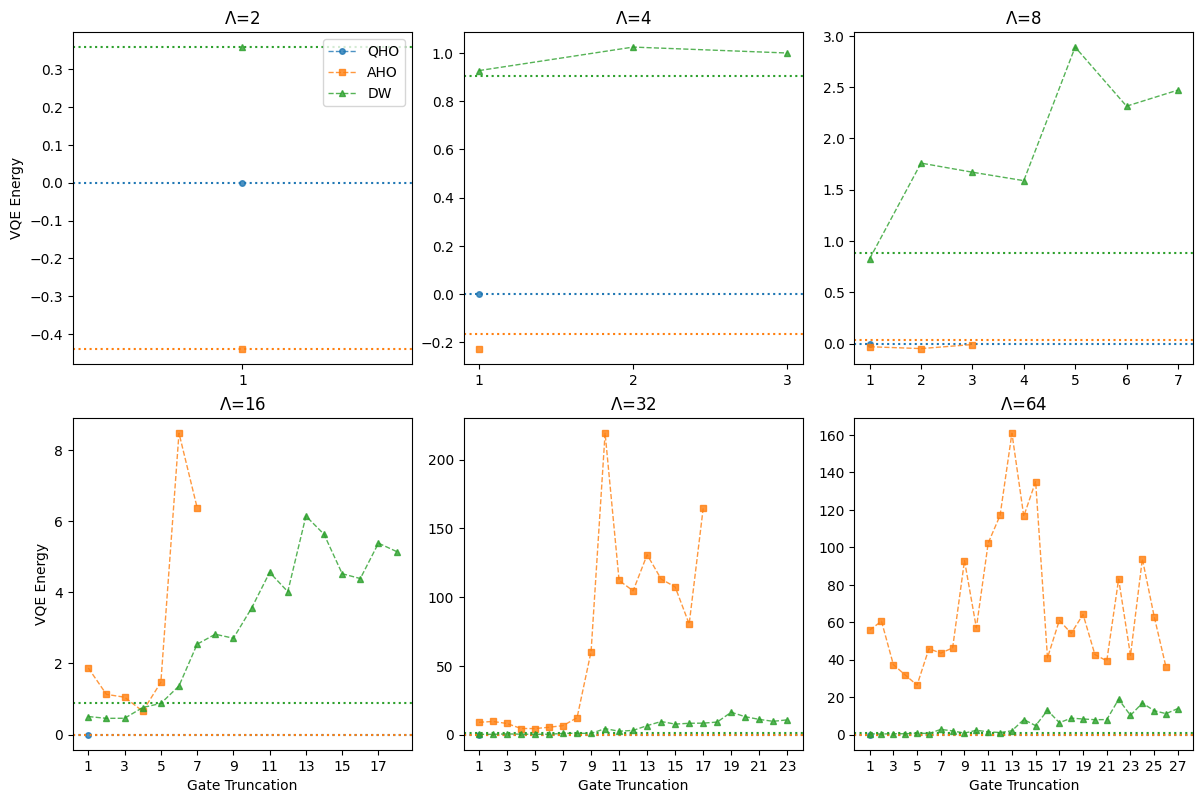

In [11]:
markers = ["o", "s", "^", "D", "v", "P", "*", "X"]
potentials = ["QHO","AHO","DW"]
cutoffs = [2,4,8,16,32,64]

#plt.figure(figsize=(7,4))
fig, axes = plt.subplots(2, 3, figsize=(12,8), sharex=False, sharey=False)

for i, cutoff in enumerate(cutoffs):
    row, col = divmod(i, 3)         
    ax = axes[row, col]

    for potential, marker in zip(potentials,markers):

        num_qubits = int(np.log2(cutoff)+1)

        fpath = os.path.join(repo_path, r"SUSY\SUSY QM\PennyLane\COBYQA\PauliDecomp\VQE\AnsatzSteps\10000\{}\{}".format(potential,cutoff))
        folders = [f for f in os.listdir(fpath) if os.path.isdir(os.path.join(fpath, f))]

        num_steps = len(folders)

        energies = []

        for i in range(1,num_steps+1):
            dpath = os.path.join(repo_path, r"SUSY\SUSY QM\PennyLane\COBYQA\PauliDecomp\VQE\AnsatzSteps\10000\{}\{}\max_gate_{}\{}_{}.json".format(potential,cutoff,i,potential,cutoff))

            with open(dpath, 'r') as file:
                data = json.load(file)

            results = np.asarray(data.get("results", []), dtype=float)
            success = np.asarray(data.get("success", []), dtype=bool)
            converged_idx = np.where(success)[0]
            sel = results[converged_idx]
            med_e = np.median(sel)
            energies.append(med_e)

        
        min_eigenvalue = np.min(data['exact_eigenvalues'])
        label = f"{potential}{cutoff}"

        line, = ax.plot(range(1, len(energies) + 1), energies, marker=marker, markersize= 4, linestyle='--', alpha=0.8, linewidth=1, label=potential)
        colour = line.get_color()
        ax.axhline(y=min_eigenvalue, color=colour, linestyle=':')#, label="$E_{exact}$ =" + f"{min_eigenvalue:.6f}")

        ax.set_title(f"$\\Lambda$={cutoff}")

        xticks = range(1, len(energies)  + 1)

        if len(xticks) >= 18:
            ax.set_xticks(xticks[::2])
        else:
           ax.set_xticks(xticks)
        #ax.grid(True)

#for c in range(1, axes.shape[1]):
#    for ax in axes[:, c]:
#        ax.tick_params(left=False, labelleft=False)

# x-labels only on the bottom row
for ax in axes[-1, :]:
    ax.set_xlabel('Gate Truncation')

# y-label only on the first column
for ax in axes[:, 0]:
    ax.set_ylabel('VQE Energy')

axes[0, 0].legend()

fig.tight_layout(pad=0.6)
plt.show()
#plt.savefig(r"C:\Users\Johnk\Documents\PhD\Quantum Computing Code\Quantum-Computing\SUSY\SUSY QM\PennyLane\ADAPT-VQE\Files\OpPath.png")
